In [167]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

from scipy.integrate import odeint
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
from scipy.stats import beta
import seaborn as sns
import plotly.express as px

from adjustText import adjust_text

from sklearn.impute import SimpleImputer

plt.style.use('ggplot')



### Exercise 1: Simulation of circadian gene regulation

### Question 1
1. Adapt the code from Week 9 exercises to simulate this system with rhythmic transcription and degradation rates. Modify the interactive widget such that you can vary the new parameters and plot $P(t)$ and $M(t)$.  

2. Keep the degradation rate constant (set $\epsilon_k$=0) and vary $k_0$ and $\epsilon_s$.
    * How does the phase delay between $M(t)$ and $P(t)$ changes with different values of $k_0$?
    * How does the amplitude (use the ratio between max and min) of $M(t)$ changes with different values of $k_0$? 
    
    Make sure you span a relevant range for $k_0^{-1}$ ( *i.e.* from 10 minutes to several hours).  

3. Now introduce rhythmic degradation by varying $\epsilon_k$. 
    * Show that you can obtain a rhyhtmic mRNA accumulatiokn when the synthesis is constant ($\epsilon_s=0$). 
    * Explore and discuss scenarios where the introduction of rhythmic degradation leads to dynamics that cannot be achieved with a constant half-life.  
    
    See also [Wang et al., 2018](https://www.pnas.org/doi/10.1073/pnas.1715225115).

In [37]:
OMEGA = 2*np.pi/24 # 24 hour period

def s_t(t, s, epsilon):
    """
    Calculates the transcription rate at time t.

    Parameters:
    t: Time.
    s: Transcription rate (constant).
    epsilon: Amplitude of the cosine modulation.

    Returns:
    float: Transcription rate at time t.
    """
    return s*(1 + epsilon*np.cos(OMEGA*t))

def k_t(t, tk, k, epsilon):
    """
    Calculates the mRNA degradation rate at time t.

    Parameters:
    t: Time.
    tk: Time delay.
    k: mRNA degradation rate (constant).
    epsilon: Amplitude of the cosine modulation.

    Returns:
    float: mRNA degradation rate at time t.
    """
    return k*(1 + epsilon*np.cos(OMEGA*(t-tk)))

def production_decay_ode(y, time, s, km, rho, epsilon_s, epsilon_k, tk):
    """
    Defines the ODEs for the production and decay of pre-mRNA and mRNA.

    Parameters:
    y: List of initial conditions [P, M].
    time: Time vector.
    s: Transcription rate (constant).
    km: mRNA degradation rate.
    rho: Splicing rate.
    epsilon_s: Amplitude of the cosine modulation for transcription rate.
    epsilon_k: Amplitude of the cosine modulation for mRNA degradation rate.
    tk: Time delay.

    Returns:
    list: List of derivatives [dPdt, dMdt].

    This function defines the ordinary differential equations (ODEs) for the production and decay of pre-mRNA and mRNA.
    It calculates the derivatives of pre-mRNA and mRNA concentrations with respect to time.
    """
    P, M  = y
    dPdt = s_t(time, s , epsilon_s)- rho*P
    dMdt = rho * P - k_t(time, tk, km, epsilon_k)* M
    return [dPdt, dMdt]


In [38]:

def simulation(ode_function, parameters, initial_conditions=None, time=None):
    """
    Simulate the ODEs for the production and decay of pre-mRNA and mRNA.

    Parameters:
    ode_function: The ODE function to simulate.
    parameters: A dictionary of parameters for the ODEs.
    initial_conditions: The initial conditions for the ODEs.
    time: The time intervals for the simulation.

    Returns:
    None

    This function simulates the ODEs for the production and decay of pre-mRNA and mRNA using the provided ODE function and parameters.
    It plots the simulation results for pre-mRNA and mRNA concentrations over time.
    """
    s = parameters['s']
    km = parameters['km']
    rho = parameters['rho']
    epsilon_s = parameters['epsilon_s']
    epsilon_k = parameters['epsilon_k']
    tk = parameters['tk']
    # Placeholder for adding steady-state solutions

    results = odeint(ode_function, initial_conditions, time, args=(s, km, rho, epsilon_s, epsilon_k, tk))

    plt.figure(figsize=(10, 6))
    plt.ylim([0,150])

    plt.title('Simulation of pre-mRNA and mRNA Production-Decay Dynamics')
    plt.plot(time, results[:, 0], label = 'P(t)', linewidth=2)
    plt.plot(time, results[:, 1], label = 'M(t)', linewidth=2)
    plt.legend()


    plt.xlabel("Time [min]")
    plt.ylabel("Concentration")
    plt.legend(loc='upper left')
    plt.show()
    
def animate(initial_conditions, time, s=5, km=0.05, rho=0.4, epsilon_s=0.1, epsilon_k=0.1, tk=1):
    """
    Runs the simulation with an interactive widgets for parameter exploration.
    """
      
    parameters = {'s':s, 'km':km, 'rho':rho, 'epsilon_s':epsilon_s, 'epsilon_k':epsilon_k, 'tk':tk}
    simulation(production_decay_ode, parameters, initial_conditions, time)


In [39]:

# Define initial conditions and time intervals for the simulation
initial_conditions = [0, 0] 
time = np.linspace(0, 500, 10001)

interact(animate, 
         initial_conditions=fixed(initial_conditions), 
         time=fixed(time), 
         s = (1,10,0.01), #  Transcription rate units: concentration [P] per min    
         km = (1/600,1/10,1/1000),  # mRNA degradation rate units: 1/min (range: 10 min to 600 min)
         rho = (1/30,1,0.05), #splicing rate units: 1/min (range: 1 min to 30 min)
         epsilon_s = (0,1,0.01),
         epsilon_k = (0,1,0.01),
         tk = (0,50,0.01)); 

interactive(children=(FloatSlider(value=5.0, description='s', max=10.0, min=1.0, step=0.01), FloatSlider(value…

### Exercise 2: Circadian (post-)transcriptional regulation of gene expression in mouse liver

In this exercise, we will analyse published RNA-seq data from mouse liver under an *ad libitum* feeding regimen and in presence of a 12-hour light-dark cycle ([Atger et al., 2015](https://www.pnas.org/doi/abs/10.1073/pnas.1515308112)). The samples were harvested every 2 hours in four replicates, RNA was extracted and sequenced. Similarly to Week 9 exercises on RNA-seq data, gene expression was quantified at the intron and exon levels. Note that data are $log_2$ transformed and normalized (RPKM).

### Question 1
1. Modify the code from Week 9 exercises to perform PCA using the 14 following genes (core clock genes and selected clock output genes):  
 ``['Arntl', 'Npas2', 'Clock', 'Cry1', 'Cry2', 'Per1', 'Per2', 'Per3', 'Nr1d1', 'Nr1d2', 'Rora', 'Rorc', 'Tef', 'Dbp']``.  
 First start with only the exons, then only the introns, and eventually both. Describe your observations.  

2. Use the *return_amp_phase_pv* function on the $log_2$ data to assess and characterize rhythmicity genome-wide.
    * Select genes based on p-value ($p<0.01) and amplitude (log2 fold-change>0.5) thresholds for further analysis.
    * Provide histograms of the peak times, and amplitudes ($log_2$ peak-to-trough) for the selected genes.
    * Perform this analysis separately for the exons and introns.
    * Examine whether you observe patterns typically referred to as the 'morning' and 'evening' waves of gene expression.
    
3. Determine which genes show the highest amplitude rhythmic patterns. Are there any common themes or characteristics among these genes?

In [40]:
dat = pd.read_csv("./GSE73554_WT_AL_Intron_Exon_RFP.txt",sep='\t')
dat.index = dat['Gene_Symbol']
dat = dat.drop(['Gene_Symbol','Gene_Ensembl'], axis=1)
dat.columns = dat.columns.str.split('_', expand = True)
dat.columns.names = ['condition','feeding','feature','time','replicate']

display(dat)

condition            WT                                                    \
feeding              AL                                                     
feature          Intron                                                     
time                 00        02        04        06        08        10   
replicate             A         A         A         A         A         A   
Gene_Symbol                                                                 
Gnai3         -1.564402 -1.536626 -1.931707 -1.458354 -1.575970 -1.654038   
Cdc45         -3.838233 -4.132913 -4.023130 -3.782926 -3.971205 -3.898270   
Apoh          -1.075680 -1.540220 -1.569142 -1.652602 -1.786800 -1.539642   
Narf          -1.198793 -0.937221 -0.921084 -0.331866 -0.123671 -0.186613   
Cav2          -3.046334 -3.741371 -3.364087 -3.063080 -3.374724 -2.992739   
...                 ...       ...       ...       ...       ...       ...   
D630044L22RIK -4.321928 -4.321928 -4.321928 -4.321928 -4.321928 -4.321928   
Ptges3l       -3.347417 -3.618811 -3.908509 -3.526344 -4.037561 -3.943861   
RP23-206J9.3  -2.691658 -3.027459 -2.962016 -2.628984 -2.712101 -2.554431   
A130051J06Rik -4.321928 -4.321928 -4.321928 -4.321928 -4.321928 -4.321928   
RP24-414A22.6 -3.130522 -2.951066 -3.093629 -2.589265 -2.661218 -2.837659   

condition                                              ...             \
feeding                                                ...              
feature                                                ...        RFP   
time                 12        14        16        18  ...         04   
replicate             A         A         A         A  ...          D   
Gene_Symbol                                            ...              
Gnai3         -1.550707 -1.564596 -1.211372 -1.654187  ...   4.739938   
Cdc45         -3.837377 -3.907227 -4.002231 -3.837719  ...  -1.783427   
Apoh          -1.434320 -1.655522 -1.499171 -1.411709  ...  10.657651   
Narf          -0.632810 -0.963087 -0.999763 -1.320254  ...   1.788997   
Cav2          -2.985271 -2.991166 -2.954387 -3.052015  ...   0.759856   
...                 ...       ...       ...       ...  ...        ...   
D630044L22RIK -4.321928 -4.321928 -3.916656 -4.211345  ...  -4.321928   
Ptges3l       -4.174696 -3.921224 -3.780628 -3.005190  ...  -1.591447   
RP23-206J9.3  -2.718235 -2.661330 -2.389922 -2.353155  ...   1.876491   
A130051J06Rik -4.321928 -3.839064 -4.321928 -4.321928  ...  -3.971570   
RP24-414A22.6 -3.019553 -2.914291 -2.770331 -2.818499  ...   2.722619   

condition                                                             \
feeding                                                                
feature                                                                
time                  06         08         10         12         14   
replicate              D          D          D          D          D   
Gene_Symbol                                                            
Gnai3           4.648414   4.576937   4.891934   5.284247   5.502545   
Cdc45          -1.045727  -1.868940  -1.616297   1.552717   0.336330   
Apoh           10.460193  10.623698  10.381588  10.146668  10.232355   
Narf            2.660656   2.890531   3.379632   2.924193   2.472548   
Cav2            0.403964   0.581452   0.716145   0.742948   0.385111   
...                  ...        ...        ...        ...        ...   
D630044L22RIK  -4.321928  -4.321928  -3.875723  -4.321928  -4.321928   
Ptges3l        -0.918822  -2.252870  -2.462090   0.296977  -0.849123   
RP23-206J9.3    2.159512   2.119404   2.231766   2.003449   1.770509   
A130051J06Rik  -4.321928  -3.154010  -4.052683  -4.064130  -4.073789   
RP24-414A22.6   3.077116   3.173420   2.842354   2.942225   2.968706   

condition                                                  
feeding                                                    
feature                                                    
time                  16         18        

In [126]:
#first we select the 14 genes we want to analyse 
GENES = ['Arntl', 'Npas2', 'Clock', 'Cry1', 'Cry2', 'Per1', 'Per2', 'Per3', 'Nr1d1', 'Nr1d2', 'Rora', 'Rorc', 'Tef', 'Dbp']
dat_select = dat.loc[GENES]


In [62]:
# We look at our features
display('replicate:',dat_select.columns.get_level_values('replicate').unique(),
        'feature:',dat_select.columns.get_level_values('feature').unique(),
        'time:', dat_select.columns.get_level_values('time').unique(),
        'condition:', dat_select.columns.get_level_values('condition').unique(),
        'feeding:', dat_select.columns.get_level_values('feeding').unique(),
        dat_select.index.unique())


# Access the row corresponding to the gene symbol
row = dat_select.loc[GENES]

# Print the feature name
print(dat_select.columns.get_level_values('feature').unique())

exon_count = dat_select.xs('Exon', axis=1, level='feature').notna().sum().sum()
intron_count = dat_select.xs('Intron', axis=1, level='feature').notna().sum().sum()

print(f"exon {exon_count} \nintron {intron_count}")


'replicate:'

Index(['A', 'B', 'C', 'D'], dtype='object', name='replicate')

'feature:'

Index(['Intron', 'Exon', 'RFP'], dtype='object', name='feature')

'time:'

Index(['00', '02', '04', '06', '08', '10', '12', '14', '16', '18', '20', '22'], dtype='object', name='time')

'condition:'

Index(['WT'], dtype='object', name='condition')

'feeding:'

Index(['AL'], dtype='object', name='feeding')

Index(['Arntl', 'Npas2', 'Clock', 'Cry1', 'Cry2', 'Per1', 'Per2', 'Per3',
       'Nr1d1', 'Nr1d2', 'Rora', 'Rorc', 'Tef', 'Dbp'],
      dtype='object', name='Gene_Symbol')

Index(['Intron', 'Exon', 'RFP'], dtype='object', name='feature')
exon 672 
intron 672


In [53]:
def run_PCA_og(data, n_components=5, color_by='replicate', symbol_by='time', scale_data=True, log_transform=False, grad=True):
    
    """
    Runs PCA on the provided data and generates a scatter plot of pairs of principal components.
    It also returns a DataFrame containing the PCA loadings.

    Parameters:
    data: The gene expression data to analyze.
    n_components: The number of principal components to calculate.
    color_by: The metadata category to color the data points by.
    symbol_by: The metadata category to symbolize the data points by.
    scale_data: Whether to scale the data before PCA.
    log_transform: Whether to apply log transformation to the data.
    grad: Whether to apply gradient palette to the data.
    
    Returns:
    pd.DataFrame: A DataFrame containing the PCA loadings.
    """
    data_tmp = data.copy()
    
    # Scale and/or log-transform the data if specified
    if scale_data:
        data = scale(data)
    else:
        data = data
        
    if log_transform:
        data = np.log2(data + 1)
    
    # apply gradient palette to data if specified
    if grad:
        color_palette = 'Blues'
    else:
        color_palette = 'Set1'
        
    # Fit the PCA model
    pca = PCA(n_components=n_components)
    pca.fit(data.T)

    # Transform the data
    pca_transformed = pca.transform(data.T)

    # Create a DataFrame for the PCA results
    labels = [f'PC{i+1}' for i in range(n_components)]
    pca_df = pd.DataFrame(pca_transformed, columns=labels)
    pca_df[color_by] = data_tmp.columns.get_level_values(color_by)
    pca_df[symbol_by] = data_tmp.columns.get_level_values(symbol_by)

    # Plotting each pair of consecutive principal components
    fig, axes = plt.subplots(1, n_components -1, figsize=(30, 5))
    for i in range(n_components-1):
        sns.scatterplot(ax=axes[i], data=pca_df, x=f'PC{i+1}', y=f'PC{i+2}', 
        hue=color_by, style=symbol_by, s=200, palette=color_palette)

        axes[i].set_xlabel(f'PC{i+1} ({pca.explained_variance_ratio_[i]*100:.2f}%)')
        axes[i].set_ylabel(f'PC{i+2} ({pca.explained_variance_ratio_[i+1]*100:.2f}%)')
        # remove legend if it's not the first plot
        if i != 0:
            axes[i].get_legend().remove()
    
    fig.suptitle(f'PCA of Gene Expression Data (color={color_by}, symbol={symbol_by})', fontsize=16)

    # Return the PCA loadings
    df_pca = pd.DataFrame(pca.components_, columns=data_tmp.index, index=labels)

    return df_pca

In [44]:
def subselect(data, feature, time):

    """
    Subselects samples from the full dataset based on the specified features, conditions, 
    replicates, and time points.

    Parameters:
    data: The full gene expression dataset.
    feature: The features to filter by (e.g., ['intron', 'exon']).
    replicate: The replicates to include.
    time: The time points to include.
    condition: The temperature shift conditions to include (e.g, ['33to38', '38to33']).

    Returns:
    pd.DataFrame: The filtered dataset.
    """

    # Create boolean masks for each filtering criterion

    feature_mask  = data.columns.get_level_values('feature').isin(feature)
    #condition_mask  = data.columns.get_level_values('condition').isin(['WT'])
    #replicate_mask  = data.columns.get_level_values('replicate').isin(replicate)
    time_mask = data.columns.get_level_values('time').isin(time)
    #feeding_mask = data.columns.get_level_values('feeding').isin(['AL'])
    
    # Use the masks to filter the data

    filtered_data = data.iloc[:, feature_mask & time_mask]
    
    return filtered_data


In [45]:

dat_select_tf = dat_select.copy()
dat_select_tf.columns = dat_select.columns.droplevel([0, 1])



In [46]:
display( dat_select)

condition          WT                                                    \
feeding            AL                                                     
feature        Intron                                                     
time               00        02        04        06        08        10   
replicate           A         A         A         A         A         A   
Gene_Symbol                                                               
Arntl       -1.669041 -1.694083 -2.706959 -3.508204 -3.848818 -4.003520   
Npas2       -1.962732 -2.192843 -3.944118 -4.209720 -4.256702 -4.273067   
Clock       -1.597633 -1.549136 -1.794397 -1.740208 -2.561197 -2.653104   
Cry1        -3.015745 -2.888921 -3.226192 -3.355850 -3.444067 -2.907677   
Cry2        -2.125658 -1.418011 -1.267150 -0.570111 -0.933872 -0.568488   
Per1        -3.628741 -2.709595 -3.435573 -2.387584 -1.056242 -0.152236   
Per2        -3.124204 -3.159253 -2.878459 -1.982470 -1.676214 -1.620635   
Per3        -3.495905 -3.181697 -2.035363 -0.022370 -0.187357  0.141948   
Nr1d1       -3.736364  0.629202  1.124620  2.043870  0.982958  0.511537   
Nr1d2       -2.381752 -0.994712 -0.407671  0.606150  0.358367  0.340322   
Rora        -2.693287 -2.700310 -2.593670 -2.170328 -2.909943 -2.726880   
Rorc        -1.253206 -1.378898 -1.536282 -0.618622 -0.467160  0.278091   
Tef         -1.868908 -0.891298  0.191412  1.471059  1.801677  1.936604   
Dbp         -4.008243 -2.292534  0.462570  2.588438  2.665088  2.456974   

condition                                            ...                      \
feeding                                              ...                       
feature                                              ...       RFP             
time               12        14        16        18  ...        04        06   
replicate           A         A         A         A  ...         D         D   
Gene_Symbol                                          ...                       
Arntl       -3.509194 -2.494314 -2.238684 -2.282043  ...  3.022983  1.673178   
Npas2       -4.269427 -4.246326 -4.237317 -4.149953  ... -0.111984 -3.286106   
Clock       -2.276997 -2.292100 -1.115022 -1.490327  ...  1.518437  1.848053   
Cry1        -2.312536 -1.554579 -1.367280 -1.529984  ...  1.572807  1.120746   
Cry2        -0.830493 -0.808692 -0.764942 -0.753802  ...  2.403922  3.050125   
Per1        -0.438939 -0.509765 -0.121126 -1.009331  ... -2.138933 -0.200017   
Per2        -0.877580 -0.834560 -0.323326 -1.117581  ... -1.610890 -0.370055   
Per3        -0.063494 -0.708187 -0.622593 -0.908967  ... -2.686956 -0.683712   
Nr1d1       -1.230222 -0.741516 -1.790100 -3.172459  ...  4.588014  6.154936   
Nr1d2       -0.094746 -0.396083 -0.858595 -1.169440  ...  1.708285  3.135121   
Rora        -2.328619 -2.963493 -2.510860 -2.949647  ...  2.293165  2.382298   
Rorc         0.713569  0.547221  1.120359  0.965740  ...  2.894547  2.889117   
Tef          1.283871  1.021040  0.917403  0.640625  ...  1.007415  2.801583   
Dbp          1.041185  0.318019 -1.223801 -0.982887  ...  1.702946  6.467692   

condition                                                                \
feeding                                                                   
feature                                                                   
time               08        10        12        14        16        18   
replicate           D         D         D         D         D         D   
Gene_Symbol                                                               
Arntl       -0.323042 -1.531355  0.016196  1.502431  0.612706  3.621233   
Npas2       -3.129760 -3.995698 -4.009316 -4.020822 -3.073643 -0.001143   
Clock        1.144557  0.770371  1.090088  1.398042  1.619607  2.039359   
Cry1         0.413170  1.039117  1.978841  2.477187  0.829508  2.543046   
Cry2         3.369495  3.397454  3.530218  3.475627  3.426552  2.585690   
Per1         1.814241  2.825217  3.149151  2.353000  0.024632 -1.356326  

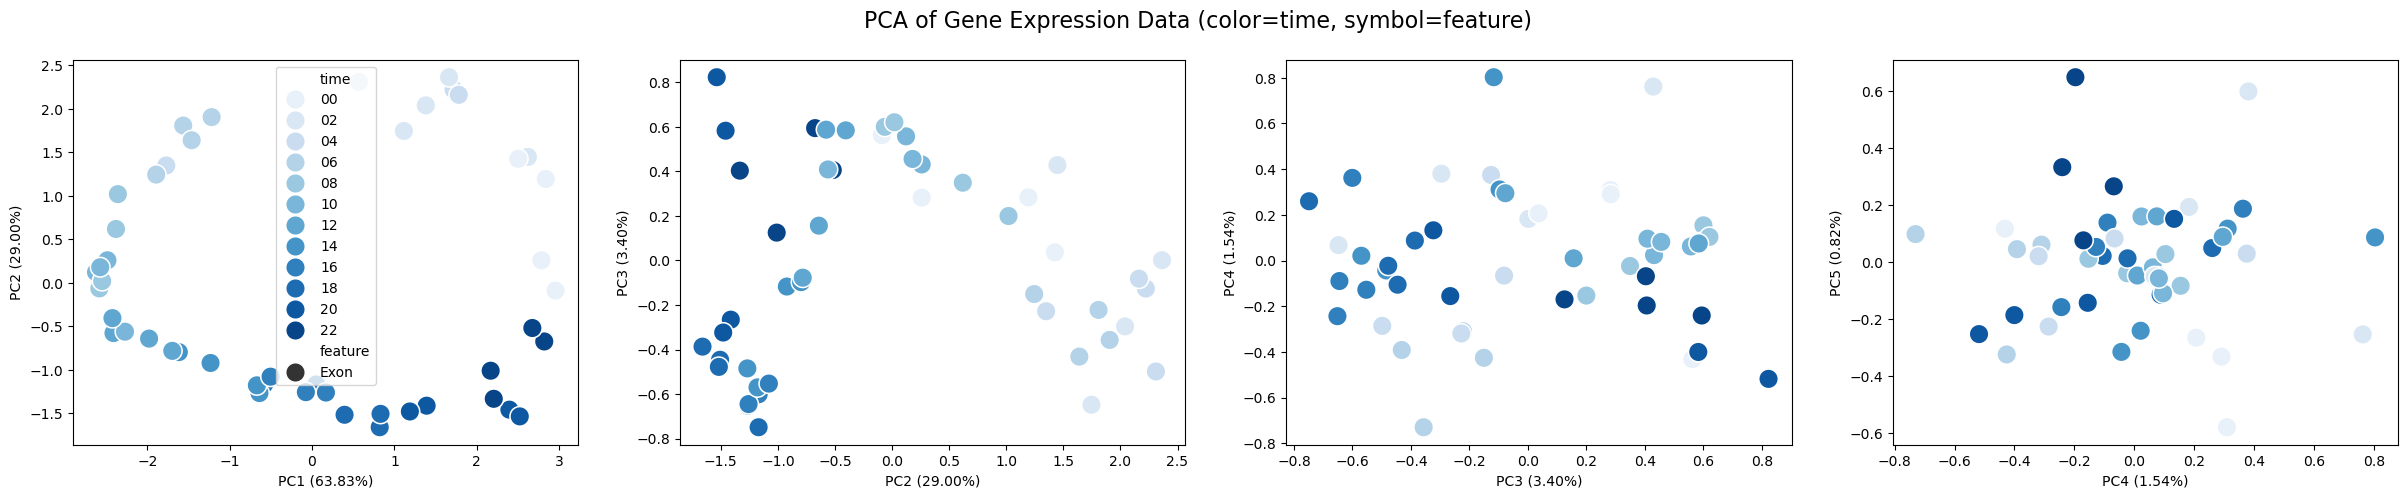

In [58]:
time= ['00', '02', '04', '06', '08', '10', '12', '14', '16', '18', '20', '22']

#Subselect the samples 
dat_sub_exon = subselect(dat_select_tf, ['Exon'], time)
dat_sub_intron = subselect(dat_select_tf, ['Intron'], time)
dat_sub_all = subselect(dat_select_tf, ['Intron', 'Exon'], time)

#Perform the PCA, plot, and return the PCA loadings. Adjust the parameters color_by and symbol_by to answer to the different question.
PC_loadings_all = run_PCA_og(dat_sub_exon, n_components=5, color_by='time', symbol_by='feature');


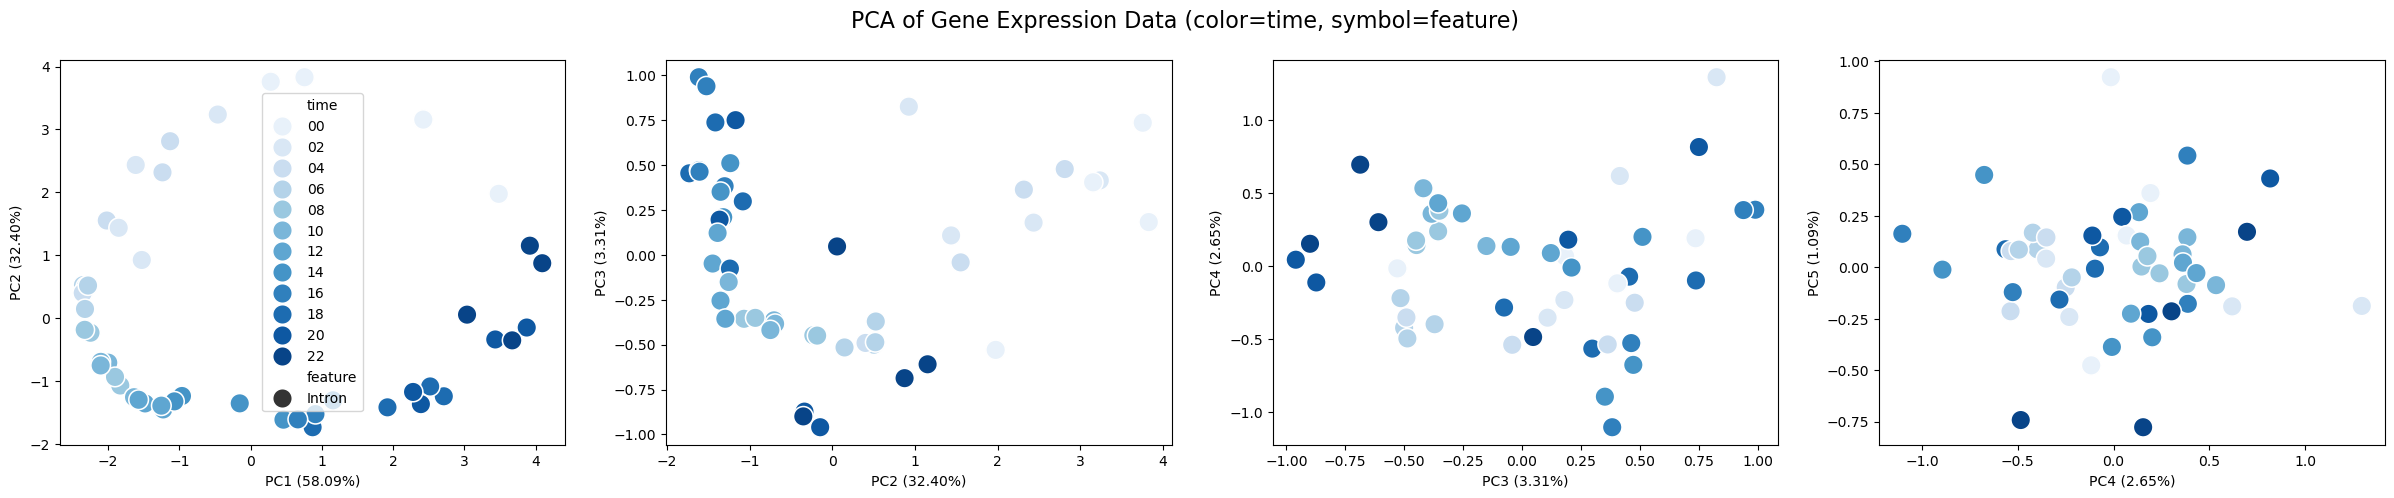

In [55]:
run_PCA_og(dat_sub_intron, n_components=5, color_by='time', symbol_by='feature');


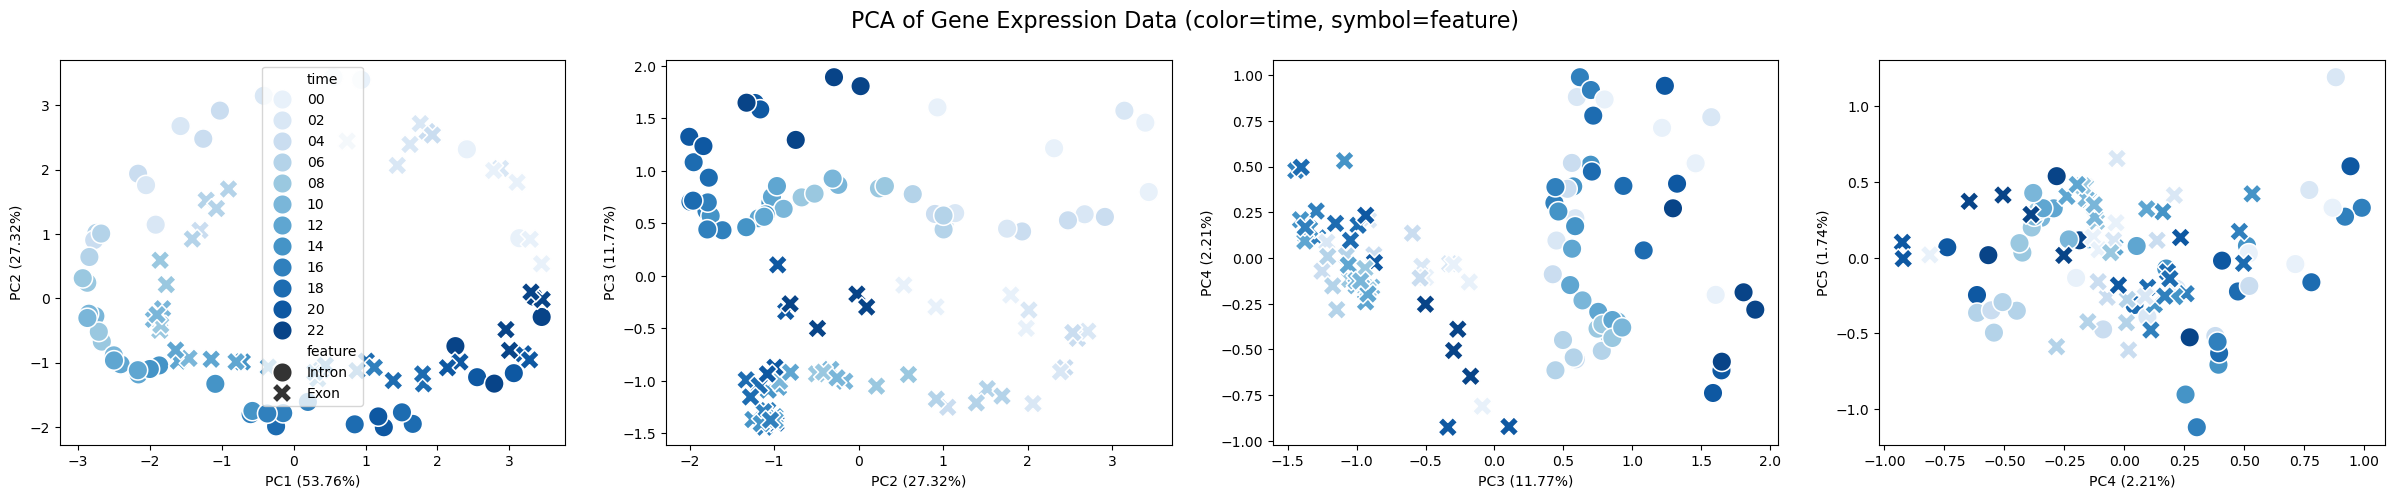

In [56]:
run_PCA_og(dat_sub_all, n_components=5, color_by='time', symbol_by='feature');


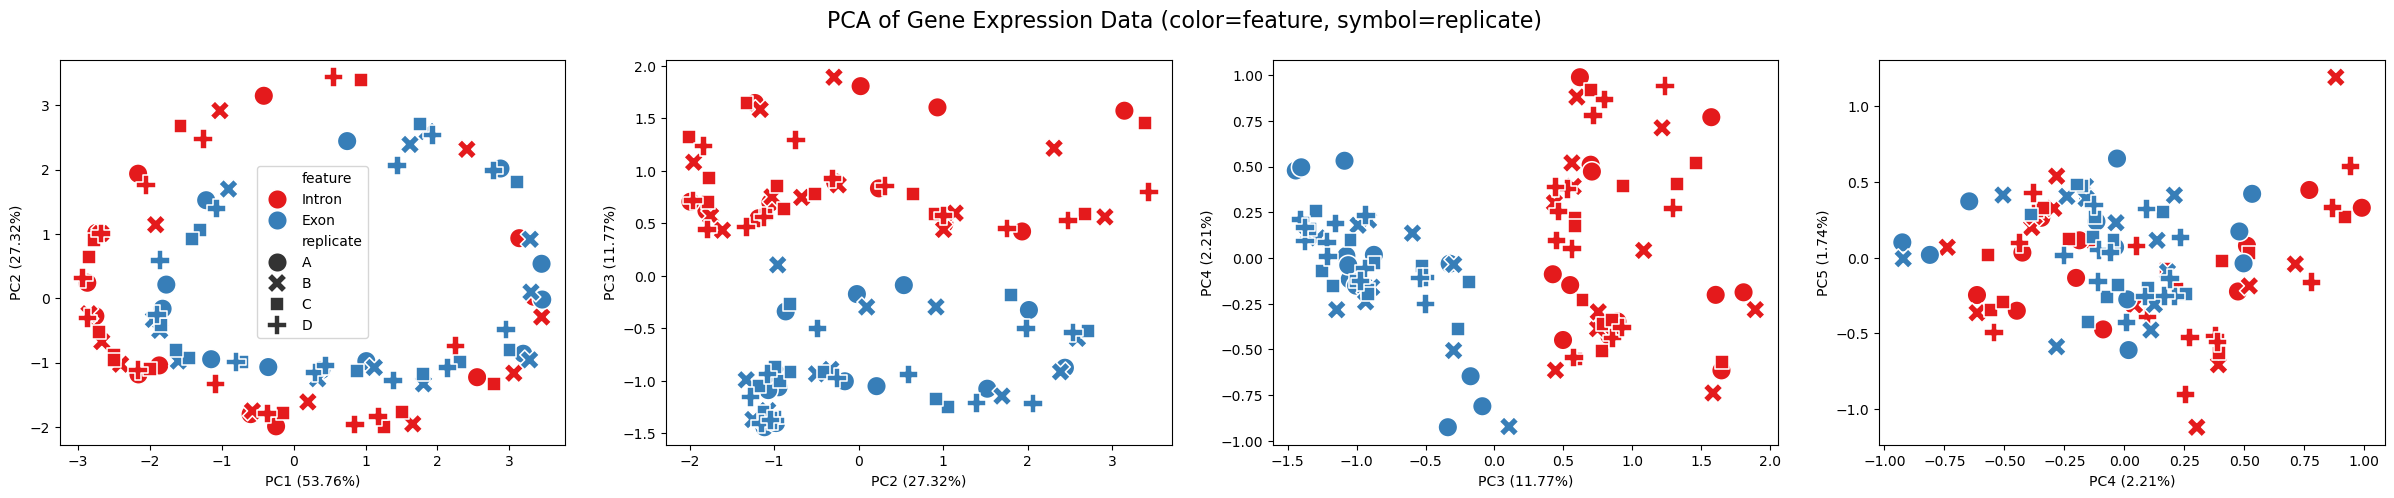

In [57]:
run_PCA_og(dat_sub_all, n_components=5, color_by='feature', symbol_by='replicate', grad = False);


---

In [59]:
# Function to infer the p-value, phase, amplitude and mean from a time-serie y with size N, period T and sampling Ts. 
def return_amp_phase_pv(y, Ts, T, N):
    
    """
    Perform harmonic regression using a Fourier series to infer the amplitude, phase, p-value, and mean from a time series.

    Parameters:
    y: Time series data.
    Ts: Sampling interval.
    T: Period of the time series.
    N: Number of data points in the time series.

    Returns:
    tuple: A tuple containing amplitude, phase, p-value, and mean of the time series.

    Notes:
    - The function uses Fast Fourier Transform (FFT) to decompose the time series.
    - Harmonic regression is performed to fit a cosine wave to the data.
    - The p-value is calculated based on the fit statistics, providing an estimate of the fit quality.
    """
      
    # Time vector for the series
    t = np.linspace(0.0, N * Ts, N)

    # Fourier Transform
    x_fft = np.fft.fft(y)
    freq = np.fft.fftfreq(len(y), d=Ts)

    # Identify the frequency closest to 1/T
    index, = np.where(np.isclose(freq, 1/T, atol=0.005))

    # Calculate amplitude and phase
    amp = 4 / N * np.abs(x_fft[index[0]])
    phase = T * np.arctan2(-x_fft[index[0]].imag, x_fft[index[0]].real) / (2 * np.pi)

    # Mean of the time series
    mu = 1 / N * x_fft[0].real
    
    # Harmonic regression to compute residuals and statistics
    x_hat = mu + 0.5 * amp * np.cos(2 * np.pi / T * t - 2 * np.pi * phase / T)
    res = y - x_hat
    sig2_1 = np.var(res)
    sig2 = np.var(y)
    R2 = 1 - sig2_1 / sig2

    # Compute p-value
    p = 3
    pval = 1 - beta.cdf(R2, (p - 1) / 2, (N - p) / 2)

    # Adjust phase to be within [0, T]
    if phase < 0:
        phase += T
        
    return amp, phase, pval, mu

In [76]:
def process_data(data, feature_type, Ts, T, N):
    """
    Applies the return_amp_phase_pv function to all genes for a given feature type (intron or exon).

    Parameters:
    data: The dataset containing gene expression data.
    feature_type: Type of feature to process ('Intron' or 'Exon').
    Ts: Sampling time.
    T: Period.
    N: Number of samples.

    Returns:
    dict: A dictionary containing arrays for amplitude, phase, p-value, and mean for the specified feature type.
    """

    feature_pos = data.columns.get_level_values('feature').isin([feature_type])
    results = {'amp': [], 'phase': [], 'pv': [], 'mu': []}

    for _, row in data.iterrows():
        a, p, pv, mu = return_amp_phase_pv(np.array(row)[feature_pos], Ts, T, N)
        results['amp'].append(a)
        results['phase'].append(p)
        results['pv'].append(pv)
        results['mu'].append(mu)

    # Convert lists to numpy arrays
    for key in results:
        results[key] = np.array(results[key])

    return pd.DataFrame(results)


In [90]:
# Apply the function to both intron and exon data
Ts = 2.0
T = 24
N = 48

results_intron = process_data(dat, 'Intron', Ts, T, N)
results_exon = process_data(dat, 'Exon', Ts, T, N)

# Select rhythmic genes based on p-value for example
significant_intron = np.logical_and(results_intron['pv'] < 0.01,results_intron['amp'] > 0.05)
significant_exon = np.logical_and(results_exon['pv'] < 0.01,results_exon['amp'] > 0.5)

significant_intron = results_intron.loc[significant_intron]
significant_exon = results_exon.loc[significant_exon]

In [118]:
display(significant_intron.head(), significant_exon.head())

,amp,phase,pv,mu
1,0.309778,14.289877,4.177863e-03,-3.879818
3,1.340003,8.569998,6.206147e-13,-0.906355
8,0.342343,12.101282,5.755650e-03,-2.272594
9,0.399129,23.172870,1.393780e-03,-3.696116
14,0.538127,4.609417,1.380777e-03,-2.475157


,amp,phase,pv,mu
1,0.887552,14.505744,1.060485e-03,-0.726735
3,1.194847,10.049716,2.605693e-13,3.335644
9,1.251987,1.782720,2.202989e-09,0.504770
14,0.613856,4.690846,7.654010e-03,0.184675
16,0.685685,8.819359,3.576385e-09,4.857602


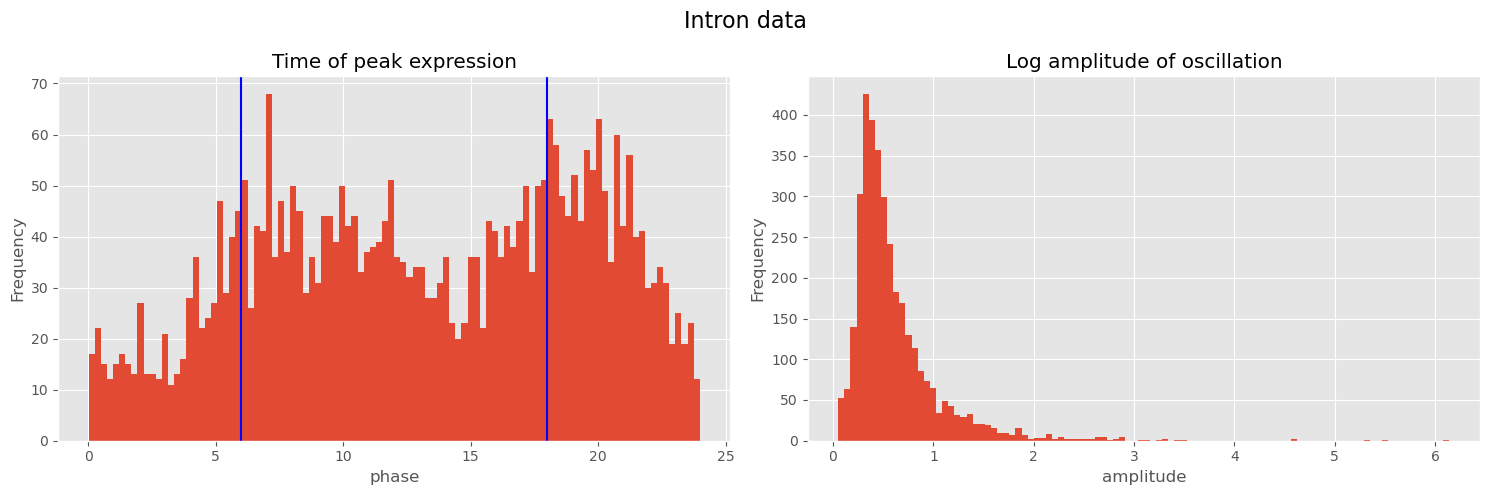

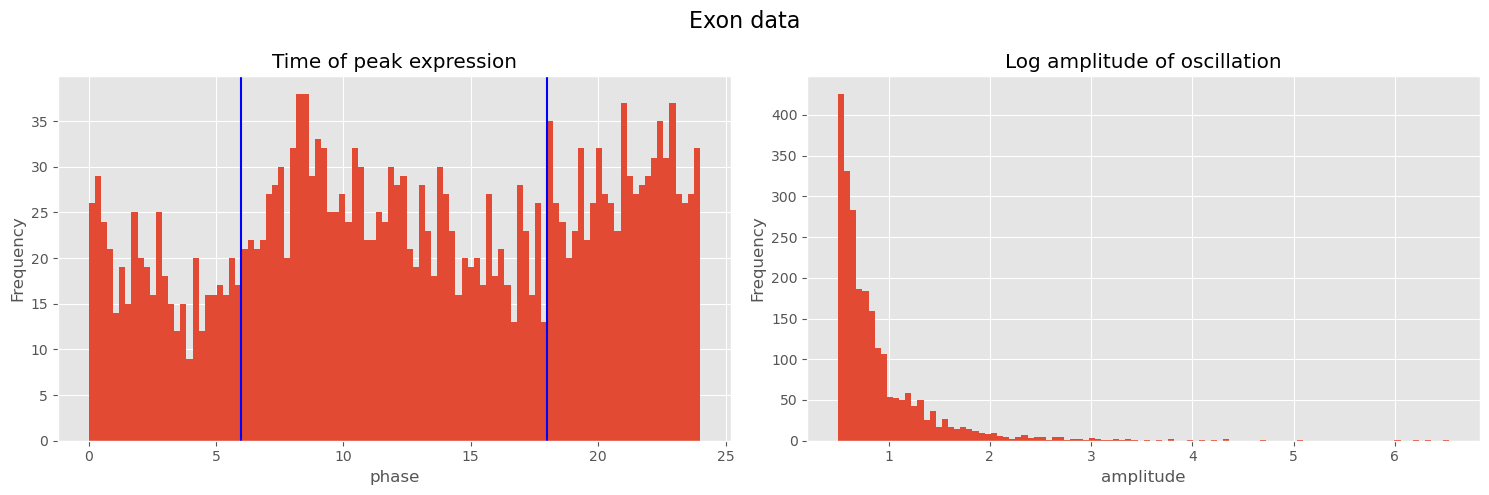

In [114]:
#Perform the different plots

def plot(data, feature):
    """
    Plot histograms of the phase and amplitude of the given data.

    Parameters:
    data (pandas.DataFrame): The data to plot. This DataFrame should have columns 'phase' and 'amp' for the phase and amplitude data, respectively.
    feature (str): The name of the feature being plotted. This will be used in the title of the plot.

    Returns:
    None
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    a = axes[0]
    b = axes[1]

    a.hist(data['phase'], bins=100)
    a.set_xlabel('phase')
    a.set_ylabel('Frequency')
    a.set_title('Time of peak expression')
    a.axvline(x=6, color='b', linestyle='-')
    a.axvline(x=18, color='b', linestyle='-')
    
    b.hist(data['amp'], bins=100)
    b.set_xlabel('amplitude')
    b.set_ylabel('Frequency')
    b.set_title('Log amplitude of oscillation')
    
    plt.suptitle(f'{feature} data', fontsize=16)
    plt.tight_layout()
    plt.show()


plot(significant_intron, 'Intron')
plot(significant_exon, 'Exon')

In [141]:
sub_df = dat.xs('Exon', level='feature', axis=1)
print(sub_df.shape, results_exon.shape)

display(dat.index.get_level_values('Gene_Symbol'))

(13480, 48) (13480, 4)


Index(['Gnai3', 'Cdc45', 'Apoh', 'Narf', 'Cav2', 'Klf6', 'Scmh1', 'Cox5a',
       'Tbx2', 'Ngfr',
       ...
       'GAPDH', 'RP23-399J8.10', 'AARSD1', 'Tnfsf12', 'Zfp87', 'D630044L22RIK',
       'Ptges3l', 'RP23-206J9.3', 'A130051J06Rik', 'RP24-414A22.6'],
      dtype='object', name='Gene_Symbol', length=13480)

In [163]:

def sort_genes(dat, results, by='Amp'):
    genes = dat.index.get_level_values('Gene_Symbol')

    sorted = pd.DataFrame(
        {'Gene': genes,
        f'{by}': results[by],
        }).sort_values(by=by, ascending=False)
    
    #sorted = sorted[sorted.Gene.isin(GENES)]
    
    return sorted


introns = dat.xs('Exon', level='feature', axis=1)
exons = dat.xs('Intron', level='feature', axis=1)

top_amp_introns = sort_genes(introns, results_intron)
top_amp_exons = sort_genes(exons, results_exon)

display('introns:', top_amp_introns.head(10), 
        'exons:', top_amp_exons.head(10))


'introns:'

,Gene,Amp
11874,Dbp,6.142029
4458,Rgs16,5.474387
2270,Nr1d1,5.307494
8807,Gm129,4.606554
8874,Elovl3,4.605279
5598,Per3,3.522691
5450,Mfsd2a,3.429768
13313,A930033H14Rik,3.316360
3276,Ccrn4l,3.292071
7993,Thrsp,3.220918


'exons:'

,Gene,Amp
4458,Rgs16,6.538457
11874,Dbp,6.342534
8807,Gm129,6.210923
2270,Nr1d1,6.053347
5450,Mfsd2a,5.059800
11427,Arntl,4.720693
4285,Npas2,4.355663
6908,Usp2,4.329795
8874,Elovl3,4.206643
5598,Per3,4.102262


In [165]:
#genes with higher amplitudes have bigger differences between the maximum and minimum values of the time series. Thus they are rhythmic
def top_amp_genes(intron, exon, n=200):
    # Select the top n  genes based on amplitude
    top_intron_genes = intron.nlargest(n, 'Amp')
    top_exon_genes = exon.nlargest(n, 'Amp')

    # Find the intersection of the gene names in both sets
    top_genes = top_intron_genes.merge(top_exon_genes, on='Gene', suffixes=('_intron', '_exon'))    
    return top_genes  

top_genes = top_amp_genes(top_amp_introns, top_amp_exons, n=200)
display(top_genes) 

,Gene,Amp_intron,Amp_exon
0,Dbp,6.142029,6.342534
1,Rgs16,5.474387,6.538457
2,Nr1d1,5.307494,6.053347
3,Gm129,4.606554,6.210923
4,Elovl3,4.605279,4.206643
...,...,...,...
93,Spon2,1.458316,2.684989
94,Bmf,1.434655,1.568346
95,Tjp3,1.432345,1.854851
96,Ypel2,1.402618,1.926628


(0.8876008805042455, 7.038456664902587)

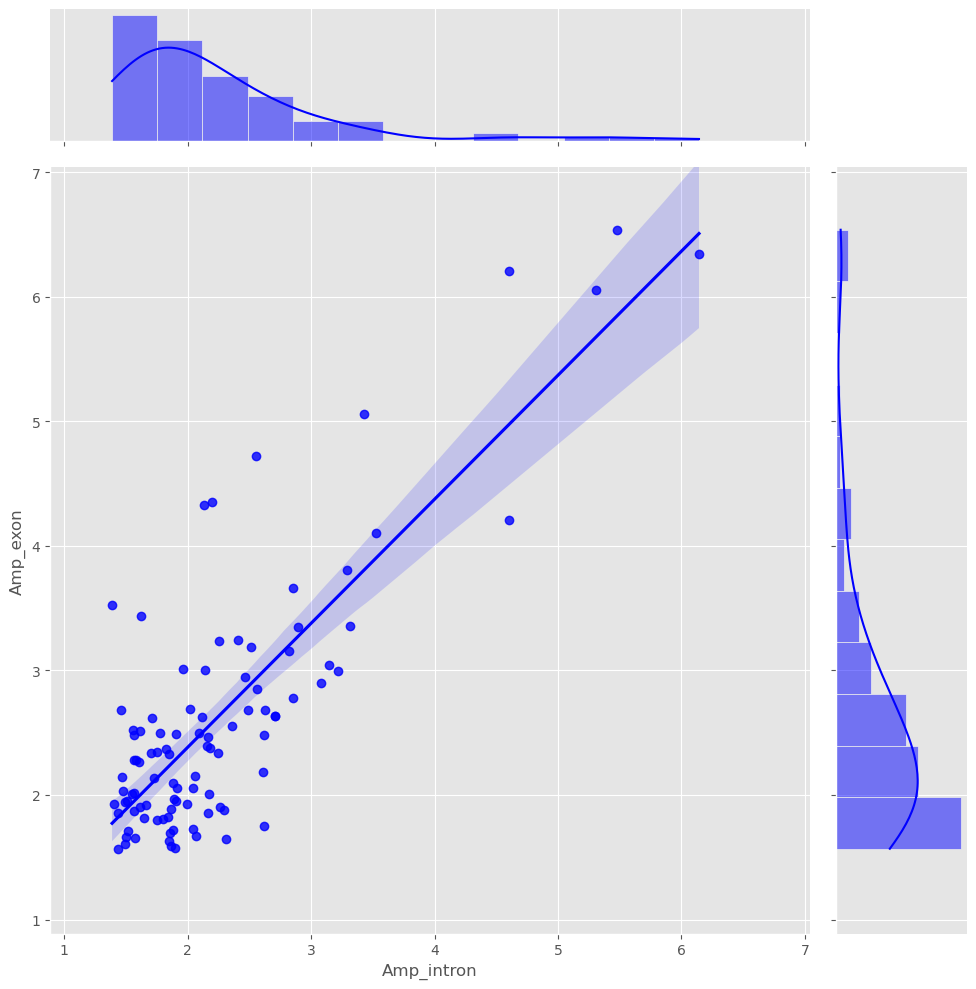

In [177]:
top_introns= top_genes['Amp_intron']
top_exons=top_genes['Amp_exon']

fig = sns.jointplot(x=top_introns, y=top_exons, kind='reg', height=10, color='b')
max_range = max(top_introns.max(), top_exons.max())+0.5
min_range = min(top_introns.min(), top_exons.min())-0.5

fig.ax_joint.set_xlim(min_range, max_range)
fig.ax_joint.set_ylim(min_range, max_range)



Introns have higher amplitudes than their corresponding exon

hint: look at amplitude formula 

### Question 2
1. Related to Exercise 1, study the phase relationship between the pre-mRNA and mRNA for genes that exhibit rhythmic behavior at both the pre-mRNA and mRNA levels. Use appropriate cutoffs in your analysis to select a subset of genes that are rhythmic at both the pre-mRNA and mRNA levels. Aim to include several hundred genes for a robust analysis. 

2. Show representative profiles of genes with short or large delays.  

3. Investigate (e.g. use a scatter plot) the relation between the phase difference between pre-mRNA and mRNA and the amplitude ratio (log2 fold change) of pre-mRNA and mRNA.
    * Discuss the plot? E.g. Mark some outliers with their gene names. *Hint*: Identify genes that show exceptionally large/small phase differences or amplitude ratios compared to the general trend. 



In [290]:
def significant_rna(data, results, pv = 0.01, amp = 0.9):
    
    significant = np.logical_and(results['pv'] < pv,results['amp'] > amp)
    all_genes = data.index.get_level_values('Gene_Symbol')
    
    significant = pd.DataFrame(
        {'Gene': all_genes[significant],
        'Amp': results.amp[significant],
        'Phase': results.phase[significant]
        })   
    
    return significant

significant_genes = significant_rna(dat, results_exon).merge(significant_rna(dat, results_intron), on='Gene', suffixes=('_exon', '_intron'))
significant_genes['Phase_diff'] = np.abs(significant_genes['Phase_intron'] - significant_genes['Phase_exon'])%24

display(significant_genes.head(10))

,Gene,Amp_exon,Phase_exon,Amp_intron,Phase_intron,Phase_diff
0,Narf,1.194847,10.049716,1.340003,8.569998,1.479718
1,Pxmp4,1.027488,22.991506,1.015008,21.327316,1.664190
2,Ugp2,1.030972,10.753105,1.173855,5.400750,5.352355
3,Ccne1,2.343857,11.780155,0.953481,10.414751,1.365404
4,Ppard,2.051479,21.922179,1.209595,20.542451,1.379728
5,Angptl4,1.410443,9.752259,1.462380,8.390923,1.361337
6,Plin4,1.296351,15.308132,1.472585,15.528956,0.220823
7,Adprh,0.900216,23.520543,1.260813,22.496803,1.023740
8,Inmt,1.259121,12.134921,2.766936,8.370033,3.764887
9,Crot,1.810806,3.169849,1.797153,0.029795,3.140054


Higher amplitude exon and introns have lower phase differences

C:\Users\maxca\AppData\Local\Temp\ipykernel_33144\3752947328.py:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




C:\Users\maxca\AppData\Local\Temp\ipykernel_33144\3752947328.py:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




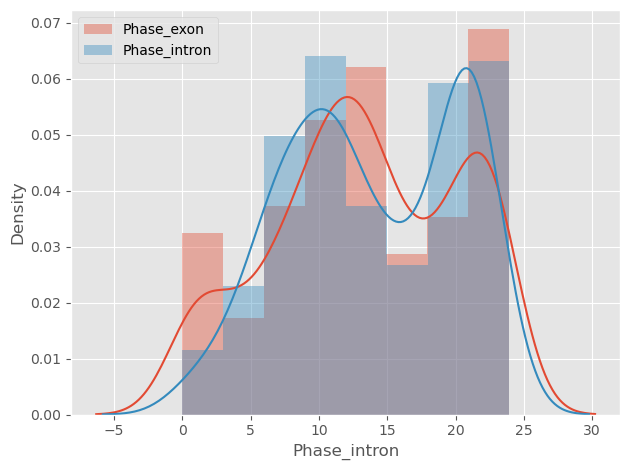

In [293]:
#plot exon phase and intron phase for the genes of interest
columns = ['Phase_exon', 'Phase_intron']


for feature in columns:
    sns.distplot(significant_genes[feature], label=feature)
    plt.legend()
    
plt.tight_layout()
plt.show()


The exon phases arrive after the intron phases

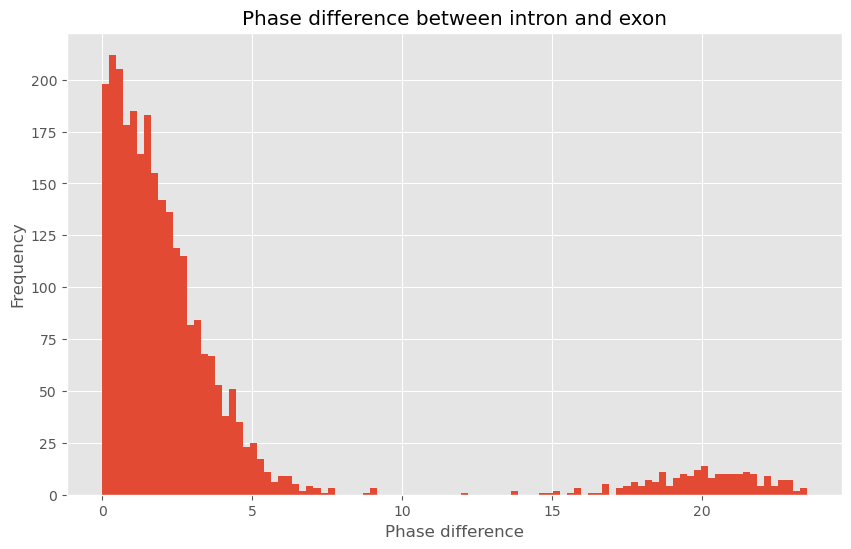

In [206]:
#we plot the phase difference between intron and exon
plt.figure(figsize=(10, 6))
plt.title('Phase difference between intron and exon')
plt.hist(significant_genes['Phase_diff'], bins=100)
plt.xlabel('Phase difference')
plt.ylabel('Frequency')
plt.show()


,Gene,Amp_exon,Phase_exon,Amp_intron,Phase_intron,Phase_diff
328,Gm15401,1.868968,0.371458,1.567739,23.867778,23.496320
226,Fam198a,1.503739,0.347914,1.145010,23.352535,23.004621
201,Rnf125,2.334535,1.022640,2.243971,23.935961,22.913321


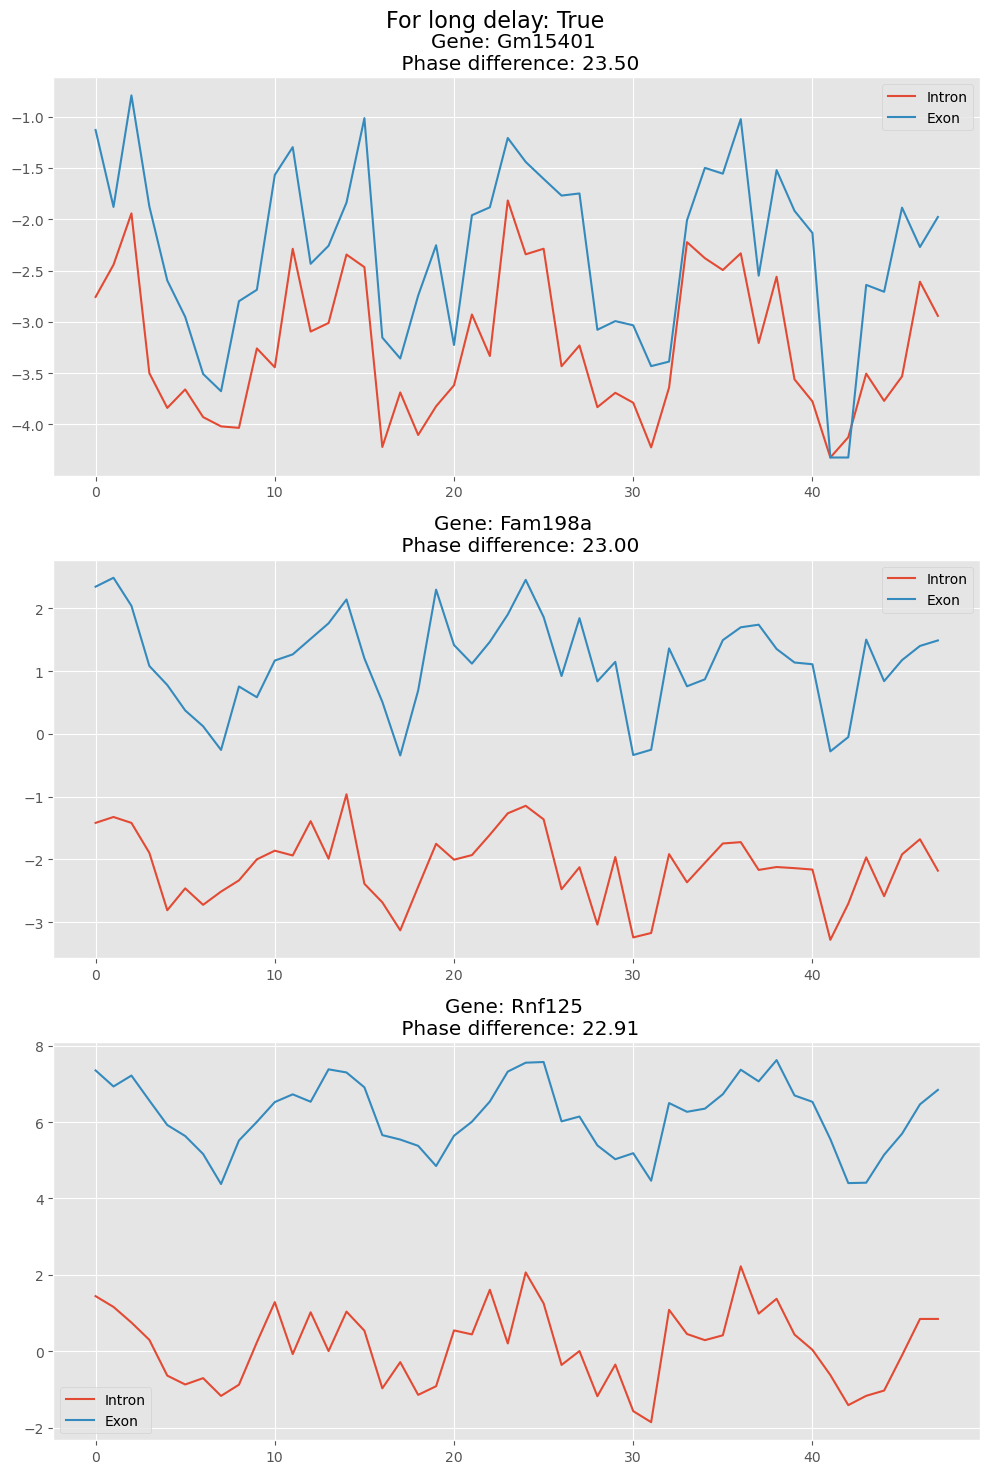

,Gene,Amp_exon,Phase_exon,Amp_intron,Phase_intron,Phase_diff
334,Arrdc3,2.552867,6.756502,2.362096,6.756413,0.000089
248,Inhba,1.105639,21.360444,1.420022,21.387695,0.027251
39,Tcp11l2,1.465544,4.896877,1.510849,4.935223,0.038345


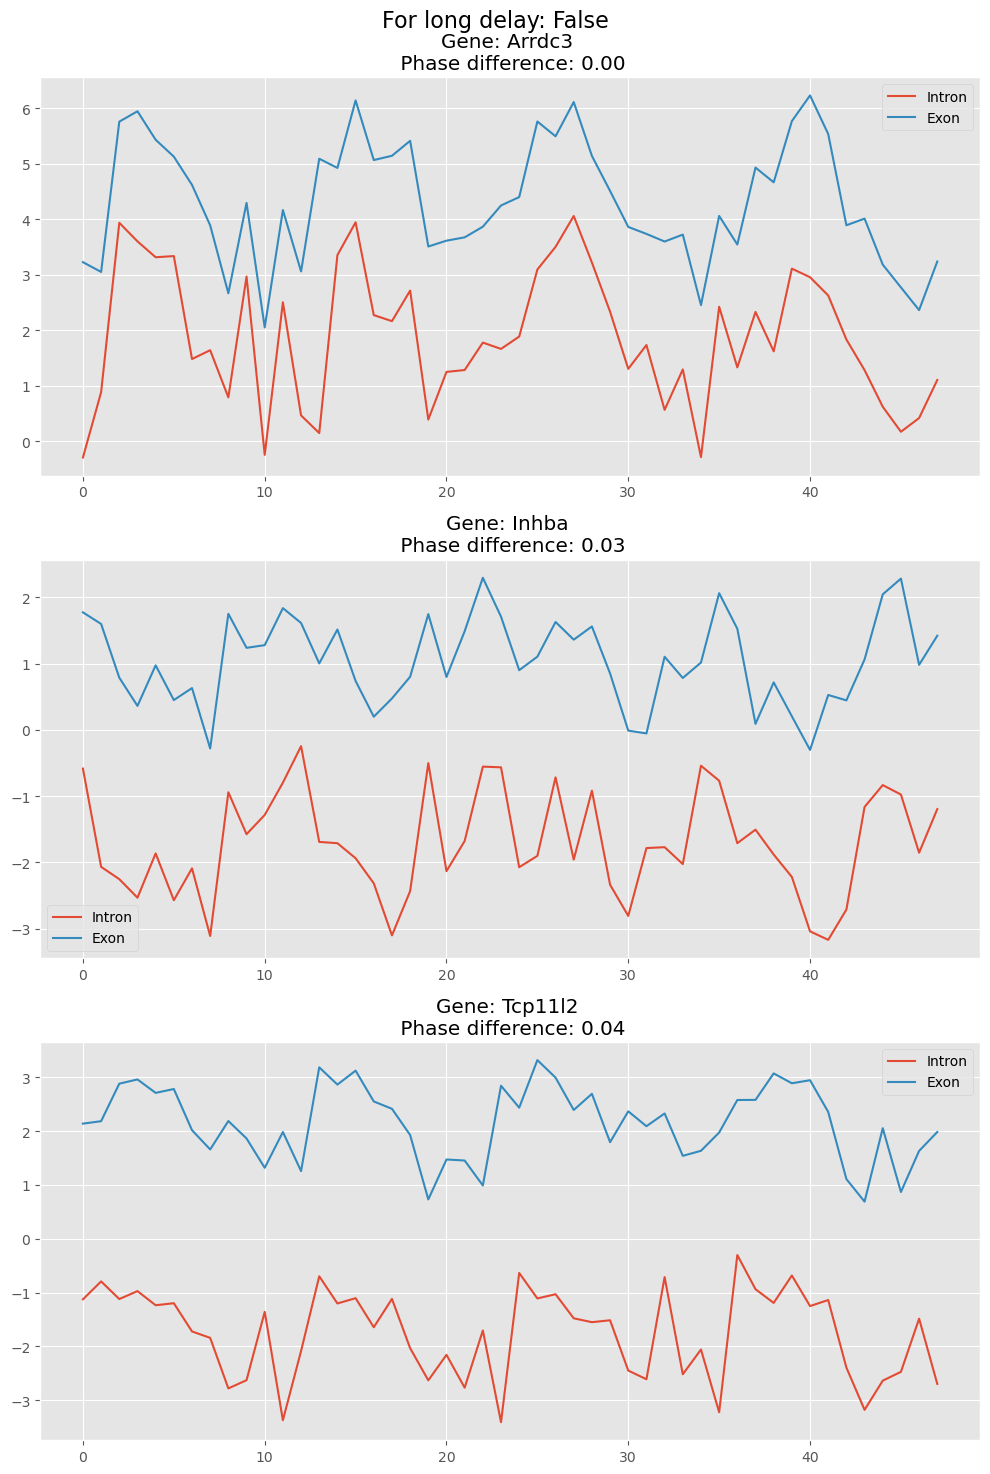

In [248]:
# We want to plot the expression data of introns and exons with big phase difference and minimal phase differences

def plot_expression(data, genes, long = True, n = 3):
    
    if long:
        genes_toplot = genes[genes.Phase_diff > 10].sort_values(by='Phase_diff', ascending=False)[:n]
    else:
        genes_toplot = genes[genes.Phase_diff < 1].sort_values(by='Phase_diff', ascending=True)[:n]
    
    display(genes_toplot)
    
    data = data.loc[genes_toplot['Gene'].values]
    
    fig, axes = plt.subplots(n, 1, figsize=(10, 5*n))
    
    for i in range(n):
        expression_intron = data.xs('Intron', axis=1, level='feature')
        y_i = expression_intron.iloc[i]
        x_i = np.arange(y_i.shape[0])
        
        expression_exon = data.xs('Exon', axis=1, level='feature')
        y_e = expression_exon.iloc[i]
        x_e = np.arange(y_e.shape[0])

        # Plot on the i-th axes
        axes[i].plot(x_i, y_i.values, label='Intron')
        axes[i].plot(x_e, y_e.values, label='Exon')
        axes[i].legend()
        axes[i].set_title(f'Gene: {genes_toplot.iloc[i]["Gene"]} \n Phase difference: {genes_toplot.iloc[i]["Phase_diff"]:.2f}')
        
    plt.suptitle(f'For long delay: {long}', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_expression(dat, genes=significant_genes , long = True)
plot_expression(dat, genes= significant_genes, long = False)

,Gene,Amp_exon,Phase_exon,Amp_intron,Phase_intron,Phase_diff
40,Cry1,2.627418,19.198665,2.117737,17.645336,1.553329
54,Nr1d1,6.053347,7.066686,5.307494,6.803025,0.263661
55,Per1,3.663637,12.917905,2.854249,12.417851,0.500054
63,Nr1d2,3.154855,9.703203,2.823723,8.367124,1.336078
73,Tef,2.775026,11.672110,2.853458,10.235907,1.436203
117,Npas2,4.355663,0.244141,2.195260,22.511198,22.267057
149,Rorc,2.182485,17.329207,2.611864,14.778460,2.550747
158,Per3,4.102262,12.219247,3.522691,10.962117,1.257129
160,Clock,1.277053,23.410925,1.209523,21.392296,2.018629
297,Arntl,4.720693,22.201291,2.552237,21.186497,1.014794


Text(0.5, 36.72222222222221, 'Amplitude of mRNA oscillation / Amplitude of pre-mRNA oscillation')

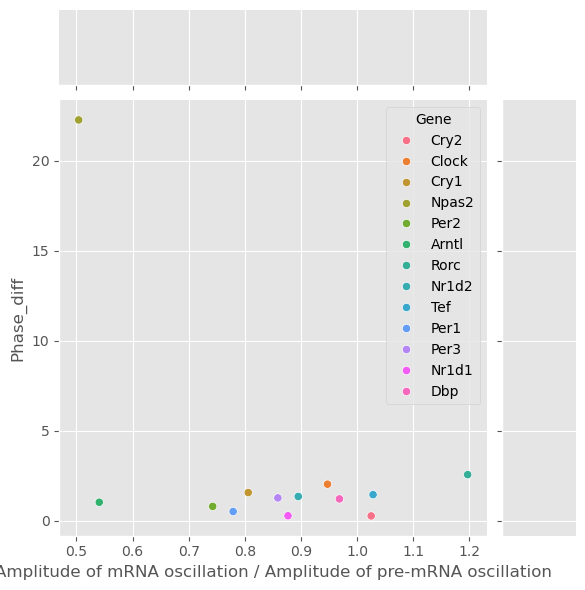

In [304]:
# Now to study the phase relationship between mRNA and pre-mRNA, we need to calculate the phase difference between the two time series.
# plot the phase difference between mRNA and pre-mRNA vs the amplitude of the mRNA oscillation
selected_significant = significant_genes[significant_genes.Gene.isin(GENES)]
display(selected_significant)
selected_significant=selected_significant.sort_values(by='Amp_intron', ascending=True)
x=selected_significant['Amp_intron']/selected_significant['Amp_exon']

sns.jointplot(x=x, y=selected_significant.Phase_diff, hue=selected_significant.Gene)
plt.xlabel('Amplitude of mRNA oscillation / Amplitude of pre-mRNA oscillation')

Text(0.5, 36.72222222222221, 'Amplitude of mRNA oscillation / Amplitude of pre-mRNA oscillation')

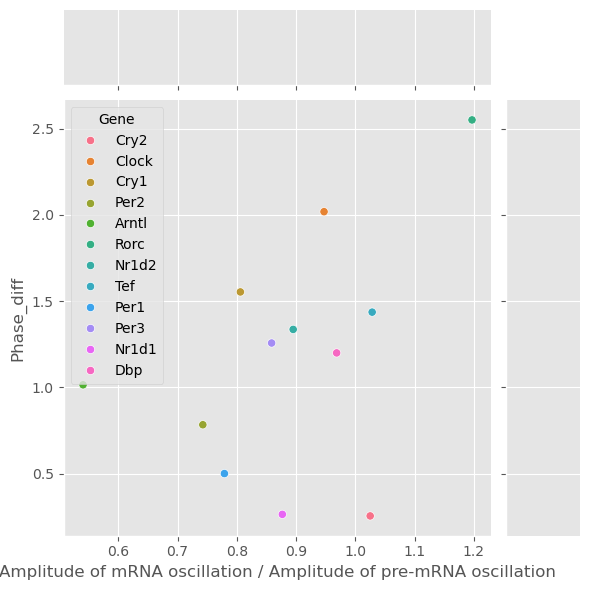

In [305]:
selected_significant=selected_significant.drop(117)
x=selected_significant['Amp_intron']/selected_significant['Amp_exon']

sns.jointplot(x=x, y=selected_significant.Phase_diff, hue=selected_significant.Gene)
plt.xlabel('Amplitude of mRNA oscillation / Amplitude of pre-mRNA oscillation')

Npas2 is an obvious outlier with a phase difference of 22hours

The second plot is without the outlier to see the other genes better